In [1]:
import pandas as pd
from pandas import Series, DataFrame
from pandas_datareader import DataReader
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns
from scipy import stats
import time
from datetime import datetime, timedelta

import poloniex

In [2]:
polo = poloniex.Poloniex()
period = polo.DAY # period of data
end = time.time()
start = end - period * 365 # 1 year

coin_name_list = ['BTC', 'ETH', 'XRP']
coin_list = []

In [3]:
for coin in coin_name_list:
    print('USDT_%s'%coin)
    globals()[coin]  = DataFrame.from_dict(
                        polo.returnChartData('USDT_%s'%coin, period=period, start=start, end=end),
                        dtype=float)
    coin_list.append(globals()[coin])

USDT_BTC
USDT_ETH
USDT_XRP


In [4]:
timestamp = BTC['date'].values.tolist() # Series -> ndarray -> list
# timestamp -> year/month/day
date = [datetime.fromtimestamp(timestamp[i]).date() for i in range(len(timestamp))]

In [5]:
for COIN in coin_list:
    COIN.drop(['date', 'quoteVolume', 'weightedAverage'], axis=1, inplace=True)
    COIN.index = pd.to_datetime(date)
    COIN.index.name = 'Date'
    COIN.columns = ['High', 'Low', 'Open', 'Close', 'Volume']

In [83]:
def monte_carlo(start_price, days, dt, mu, sigma):
    prices = np.zeros(days)
    prices[0] = start_price
    
    shocks = np.zeros(days)
    drifts = np.zeros(days)
    
    for i in range(1, days):
        shocks[i] = np.random.normal(loc=0, scale=sigma*np.sqrt(dt))
        drifts[i] = mu * dt
        prices[i] = prices[i-1] + (prices[i-1] * (drifts[i] + shocks[i]))

    return prices

In [ ]:
def monte_carlo(start, n, dt, mu, sigma):
    vals = np.zeros(n)
    vals[0] = start
    
    shocks = np.zeros(n)
    drifts = np.zeros(n)
    
    for i in range(1, n):
        shocks[i] = np.random.normal(loc=0, scale=sigma*np.sqrt(dt))
        drifts[i] = mu * dt
        prices[i] = vals[i-1] + (vals[i-1] * (drifts[i] + shocks[i]))

    return vals

In [84]:
def simulateMonteCarlo(df, days, runs=5, kind='Open'):
    length = len(df) - days
    dt = 1
    returns = df[kind].head(length).pct_change()
    mu = returns.mean()
    sigma = returns.std()
    
    simudf = DataFrame(df[kind])
    
    for run in range(runs):
        simu = np.full(len(df), None)
        simu[length:] = monte_carlo(df.iloc[length][kind], days, dt, mu, sigma)

        simudf['Simulate {}'.format(run+1)] = simu
    
    return simudf

In [125]:
def predictMonteCarlo(df, days, val_days, runs=5, kind='Open', eval_end=False):
    length = len(df) - val_days
    dt = 1
    returns = df[kind].head(length).pct_change()
    mu = returns.mean()
    sigma = returns.std()
    
    simudf = DataFrame(df[kind])
    preddf = DataFrame(np.full(days, None), columns=[kind])
    preddf.index = pd.date_range(df.tail(1).index.values[0], periods=days+1, freq='D')[1:]
    simudf = pd.concat([simudf, preddf])
    
    # Simulate
    for run in range(1, runs+1):
        simu = np.full(len(df)+days, None)
        simu[length:] = monte_carlo(df.iloc[length][kind], val_days+days, dt, mu, sigma)

        simudf['Simulate {}'.format(run)] = simu
        
    # Evaluate
    score = []
    val = len(df) - 1
    goal = df[kind][val]
    for run in range(1, runs+1):
        if eval_end:
            score.append(abs(simudf['Simulate {}'.format(run)].iloc[val] - goal))
        else:
            score.append(np.mean(np.square(simudf['Simulate {}'.format(run)].iloc[length:len(df)] - simudf[kind].iloc[length:len(df)])))
    best = np.argmin(score) + 1
    for run in range(1, runs+1):
        if run == best:
            simudf['Best'] = simudf['Simulate {}'.format(run)]
        else:
            simudf['Simulate {}'.format(run)].iloc[len(df):] = None
            
    print('Best model : ', best)
    return simudf

In [ ]:
def predictMonteCarlo(df, days, val_days, runs=5, kind='Open', eval_end=False):
    length = len(df)
    dt = 1
    returns = df[kind].head(length).pct_change()
    mu = returns.mean()
    sigma = returns.std()
    
    simudf = DataFrame(df[kind])
    preddf = DataFrame(np.full(days, None), columns=[kind])
    preddf.index = pd.date_range(df.tail(1).index.values[0], periods=days+1, freq='D')[1:]
    simudf = pd.concat([simudf, preddf])
    
    # Simulate
    for run in range(1, runs+1):
        simu = np.full(len(df)+days, None)
        simu[length-val_days:] = monte_carlo(df.iloc[length-val_days][kind], val_days+days, dt, mu, sigma)
        simudf['Simulate {}'.format(run)] = simu
        
    # Evaluate
    score = []
    val = length - 1
    goal = df[kind][val]
    for run in range(1, runs+1):
        if eval_end:
            score.append(abs(simudf['Simulate {}'.format(run)].iloc[val] - goal))
        else:
            score.append(np.mean(np.square(simudf['Simulate {}'.format(run)].iloc[length-val_days:length] - simudf[kind].iloc[length-val_days:length])))
    best = np.argmin(score) + 1
    for run in range(1, runs+1):
        if run == best:
            simudf['Best'] = simudf['Simulate {}'.format(run)]
        else:
            simudf['Simulate {}'.format(run)].iloc[len(df):] = None
            
    print('Best model : ', best)
    return simudf

In [128]:
start = 200
split = 315
train = BTC.iloc[start:split]
test = BTC['Open'].iloc[split-1:]
pred = predictMonteCarlo(train, 50, 50, runs=100, eval_end=False)

Best model :  43


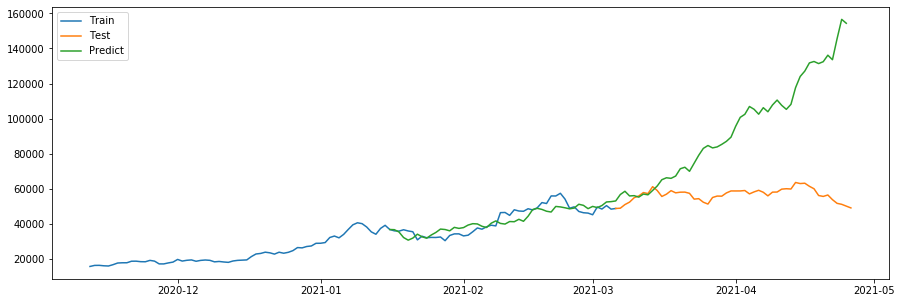

In [129]:
plt.figure(figsize=(15, 5))
plt.plot(pred['Open'])
plt.plot(test)
plt.plot(pred['Best'])
plt.legend(['Train','Test', 'Predict'])
plt.savefig('monte_carlo_predction_simu100.png')

# plt.plot(pred)
# plt.plot(test)
# plt.legend(pred.columns)

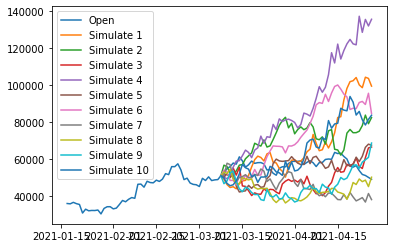

In [108]:
simulated = simulateMonteCarlo(BTC.tail(100), 50, runs=10)
plt.plot(simulated)
plt.legend(simulated.columns)

In [109]:
tech_name_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN'] #GAFA
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

tech_list = []

In [110]:
for stock in tech_name_list:
    tmp = DataReader(stock, 'yahoo', start, end)
    globals()[stock] = tmp.drop('Adj Close', axis=1)
    tech_list.append(globals()[stock])

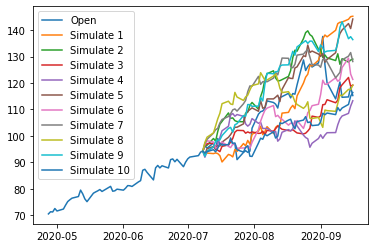

In [111]:
aapl_simu = simulateMonteCarlo(AAPL.head(100), 50, runs=10)
plt.plot(aapl_simu)
plt.legend(aapl_simu.columns)

Best model :  6


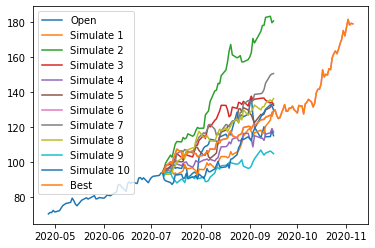

In [112]:
aapl_pred = predictMonteCarlo(AAPL.head(100), 50, 50, runs=10)
plt.plot(aapl_pred)
plt.legend(aapl_pred.columns)